##Program 2
1. Implement a denoising autoencoder that removes noise from images.
2. Train using dataset with artificially added noise.
3. Compare noisy and reconstructed images.

Epoch 1/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 620ms/step - accuracy: 0.0280 - loss: 4.2716 - val_accuracy: 0.0305 - val_loss: 3.6862 - learning_rate: 0.0010
Epoch 2/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 564ms/step - accuracy: 0.0272 - loss: 3.9709 - val_accuracy: 0.0273 - val_loss: 3.7334 - learning_rate: 0.0010
Epoch 3/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.0267 - loss: 3.8578 - val_accuracy: 0.0243 - val_loss: 3.6461 - learning_rate: 0.0010
Epoch 4/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 560ms/step - accuracy: 0.0274 - loss: 3.8247 - val_accuracy: 0.0283 - val_loss: 3.6279 - learning_rate: 0.0010
Epoch 5/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 642ms/step - accuracy: 0.0237 - loss: 3.7674 - val_accuracy: 0.0281 - val_loss: 3.6350 - learning_rate: 0.0010
Epoch 6/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 611ms/step - accuracy: 0.0300 - loss: 3.7639 - val_accuracy: 0.0273 - val_loss: 3.6578 - learning_rate: 0.0010
Epoch 7/7
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 644ms/step - accuracy: 0.0201 - loss: 3.7502 - 

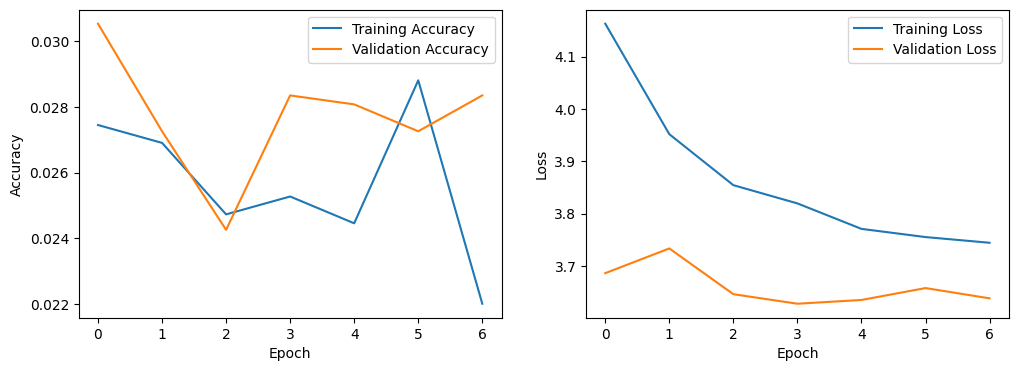

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 904ms/step - loss: 0.0675 - val_loss: 0.0340
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 688ms/step - loss: 0.0277 - val_loss: 0.0220
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 660ms/step - loss: 0.0194 - val_loss: 0.0180
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - loss: 0.0178 - val_loss: 0.0160
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 616ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - loss: 0.0145 - val_loss: 0.0139
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 640ms/step - loss: 0.0128 - val_loss: 0.0138
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - loss: 0.0126 - val_loss: 0.0134
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - loss: 0.0121 - val_loss: 0.0125
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step - loss: 0.0116 - val_loss: 0.0153
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


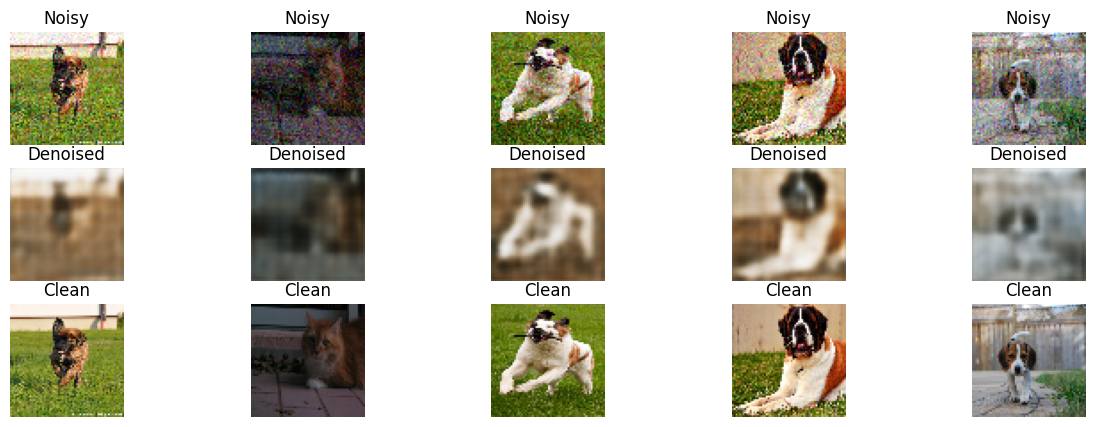

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds  # Import tensorflow_datasets
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os

# Load Oxford IIIT Pets dataset
dataset = tfds.load('oxford_iiit_pet', as_supervised=True)

# Split the dataset into train and validation
train_ds = dataset['train']
val_ds = dataset['test']

# Resize images to a consistent size and normalize
img_size = (64, 64)  # Resize to 64x64 for quicker processing
batch_size = 128

def preprocess(image, label):
    image = tf.image.resize(image, img_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    return image, label

train_ds = train_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Add noise to images
def add_noise(image, label):
    noise_factor = 0.1  # Adjust noise level - reduced for better results
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image))
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)  # Clip to valid range
    return noisy_image, image  # Return noisy image as input, clean image as target

train_ds_noisy = train_ds.map(lambda x, y: add_noise(x, y))
val_ds_noisy = val_ds.map(lambda x, y: add_noise(x, y))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),  # Reduced rotation for stability
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),  # Reduced contrast
    layers.RandomBrightness(0.1), # Reduced brightness
])

# Build the main model (CNN)
model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),
    data_augmentation,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Reduced dropout

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Reduced dropout

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),  # Reduced dropout

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(37, activation='softmax')  # 37 classes for Oxford IIIT Pets
])

# Compile the main model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for training
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

# Train the main model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,  # Reduced epochs
    callbacks=[early_stopping, lr_scheduler]
)

# Visualize training history for accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Build the Denoising Autoencoder
input_shape = (img_size[0], img_size[1], 3)

encoder = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same')
])

decoder = models.Sequential([
    layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output image
])

autoencoder = models.Sequential([encoder, decoder])

# Compile the Denoising Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Denoising Autoencoder
history_ae = autoencoder.fit(
    train_ds_noisy,
    validation_data=val_ds_noisy,
    epochs=10  # Reduced epochs
)

# Visualize denoising results
def plot_denoised_images(dataset, model, num_images=5):
    for noisy_images, clean_images in dataset.take(1):
        denoised_images = model.predict(noisy_images)
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Noisy image
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title("Noisy")
            plt.axis("off")

            # Denoised image
            plt.subplot(3, num_images, i + num_images + 1)
            plt.imshow(denoised_images[i])
            plt.title("Denoised")
            plt.axis("off")

            # Clean image
            plt.subplot(3, num_images, i + 2 * num_images + 1)
            plt.imshow(clean_images[i].numpy())
            plt.title("Clean")
            plt.axis("off")
        plt.show()

# Plot denoised images
plot_denoised_images(val_ds_noisy, autoencoder)


In [13]:
# Inside the training loop or after predicting denoised images
reconstruction_loss = autoencoder.evaluate(val_ds_noisy)  # This will evaluate the loss on the validation set
print(f"Reconstruction Loss: {reconstruction_loss}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - loss: 0.0154
Reconstruction Loss: 0.015325136482715607


In [6]:
pip install tensorflow-datasets